In [7]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from rikabplotlib.plot_utils import newplot, plot_event, hist_with_errors, hist_with_outline

# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

/tmp/ipykernel_146553/1113769920.py:23: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(p[:, :, 2] / r)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/lib/function_base.py:3615: RuntimeWarning: invalid value encountered in true_divide
  return sin(y)/y


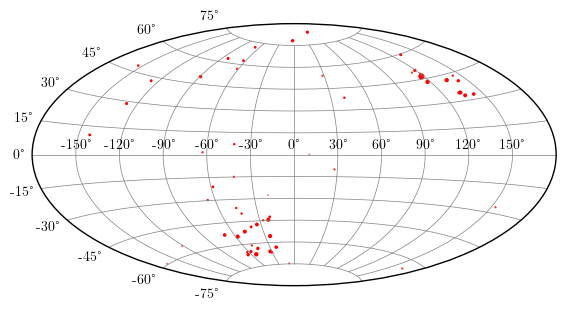

In [8]:
# Each event is an N_particles x 4 array, where the columns are E, px, py, pz
data = np.load("/home/rikab/Documents/Research/Datasets/lep_dijets.npy")
N = data.shape[0]
N_particles = data.shape[1]


# Make massless by setting E = |p|
data[:, :, 0] = np.linalg.norm(data[:, :, 1:], axis=-1)

# Normalize such that each event has an energy of 1
data[:, :, 1] /= np.sum(data[:, :, 0], axis=-1)[:, None]
data[:, :, 2] /= np.sum(data[:, :, 0], axis=-1)[:, None]
data[:, :, 3] /= np.sum(data[:, :, 0], axis=-1)[:, None]
data[:, :, 0] /= np.sum(data[:, :, 0], axis=-1)[:, None]


# Get the spherical coordinates of the particles

def spherical_coordinates(data):
    p = data[:, :, 1:]
    r = np.linalg.norm(p, axis=-1)
    data[:,:,0] = r
    theta = np.arccos(p[:, :, 2] / r)
    phi = np.arctan2(p[:, :, 1], p[:, :, 0])

    spherical_data = np.stack([r, theta, phi], axis=-1)
    return spherical_data


spherical_data = spherical_coordinates(data)


# Plot an event on the sphere
event = 10

fig, ax = newplot("column", subplot_kw = {"projection" :"aitoff"}, subplot_array=(1, 1), aspect_ratio= 1/np.pi)
plt.scatter(spherical_data[event, :, 2] , spherical_data[event, :, 1] - np.pi/2, s = 100*data[event, :, 0], color = "red")
plt.grid(True, color = "grey", lw = 0.5)


# test = compute_spectral_representation(spherical_data[event])

# fig, ax = newplot("column")
# plt.hist(test, bins = 100)

# # plot_event(spherical_data[event, 1:], ax=ax)


(250,)
[[ 0.9999999  -0.13223207 -0.42357045 ...  0.2993963  -0.07455216
  -0.77726436]
 [-0.13223207  0.9999999   0.9003129  ...  0.90414166 -0.7405187
   0.13867724]
 [-0.42357045  0.9003129   0.9999999  ...  0.6649497  -0.4131141
   0.553732  ]
 ...
 [ 0.2993963   0.90414166  0.6649497  ...  0.9999999  -0.78352416
  -0.2373679 ]
 [-0.07455216 -0.7405187  -0.4131141  ... -0.78352416  0.9999999
   0.43826216]
 [-0.77726436  0.13867724  0.553732   ... -0.2373679   0.43826216
   1.        ]]


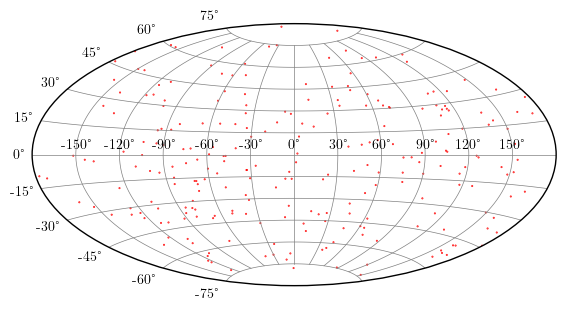

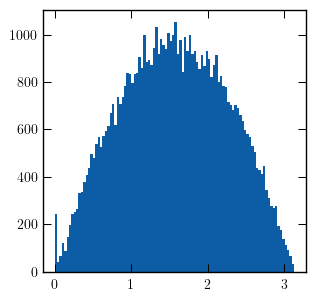

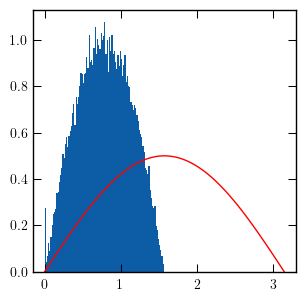

In [9]:
# Generate events, consisting of N_particles particles uniformly distributed on the sphere
N = 10000
N_particles = 250
key = random.PRNGKey(0)
key, subkey = random.split(key)

dataset2 = np.zeros((N, N_particles, 4))
for i in range(N):

    phi = np.random.uniform(0, 2*np.pi, N_particles)
    costheta = np.random.uniform(-1, 1, N_particles)
    theta = np.arccos(costheta)
    r = 1 / N_particles
    energy = np.ones(N_particles) / N_particles

    dataset2[i, :, 0] = r
    dataset2[i, :, 1] = r * np.sin(theta) * np.cos(phi)
    dataset2[i, :, 2] = r * np.sin(theta) * np.sin(phi)
    dataset2[i, :, 3] = r * np.cos(theta)

# Plot an event on the sphere
event = 10
spherical_data2 = spherical_coordinates(dataset2)


fig, ax = newplot("column", subplot_kw = {"projection" :"aitoff"}, subplot_array=(1, 1), aspect_ratio= 1/np.pi)
plt.scatter(spherical_data2[event, :, 2] , spherical_data2[event, :, 1]- np.pi/2 , s = 50*spherical_data2[event, :, 0], color = "red")
plt.grid(True, color = "grey", lw = 0.5)



points, zs = dataset2[0,:,1:], dataset2[0,:,0]
print(zs.shape)

# angles[0][0]

thetas =  jnp.arccos(jnp.sum(points[:, None, :] * points[None, :, :], axis=-1) / jnp.linalg.norm(points[:, None, :], axis=-1) / jnp.linalg.norm(points[None, :], axis=-1))
print(jnp.sum(points[:, None, :] * points[None, :, :], axis=-1) / jnp.linalg.norm(points[:, None, :], axis=-1) / jnp.linalg.norm(points[None, :], axis=-1))
# print(thetas[7,7])
newplot("column")
plt.hist(thetas.flatten(), bins = 100)


newplot("column")
test_event = np.array([[0.5, 0.5, 0, 0], [0.5, 0, 0.5, 0]])
test = compute_spectral_representation(dataset2[0], euclidean=False)
plt.hist(test[:,0], weights = test[:,1], bins = 100, density=True)
plt.plot(np.linspace(0, np.pi, 100), 0.5 * np.sin(np.linspace(0, np.pi, 100)), color = "red")

In [10]:
import time
specter = SPECTER(compile = True)


specter_emd = np.zeros((N))
batch_size = 100



test_event = np.array([[[0.5, 0.5, 0, 0], [0.5, -0.5, 0, 0]] , [[0.5, 0.5, 0, 0], [0.5, -0.5, 0, 0]]])
test_emd = specter.spectralEMD(test_event, dataset2[0:2], metric = "spherical")


for i in range(0, N, batch_size):
    start = time.time()
    specter_emd[i:i+batch_size] = specter.spectralEMD(data[i:i+batch_size], dataset2[i:i+batch_size], metric = "spherical")
    end = time.time()
    print("SPECTER took {} seconds for batch {} of {}".format(end - start, i // batch_size, N // batch_size))

np.save("isotropy.npy", specter_emd)

Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  2.6621391773223877  seconds.
Compiling spectral representation functions ...
Compiling observables...
Observables compiled! Time taken:  28.96862554550171  seconds.
Compilation complete! Time taken:  28.9686598777771  seconds.
SPECTER took 4.0824878215789795 seconds for batch 0 of 100
SPECTER took 1.388279676437378 seconds for batch 1 of 100
SPECTER took 2.2359530925750732 seconds for batch 2 of 100
SPECTER took 1.4041085243225098 seconds for batch 3 of 100
SPECTER took 1.6330528259277344 seconds for batch 4 of 100
SPECTER took 1.269179344177246 seconds for batch 5 of 100
SPECTER took 1.3024635314941406 seconds for batch 6 of 100
SPECTER took 1.3079063892364502 seconds for batch 7 of 100
SPECTER took 1.2578973770141602 seconds for batch 8 of 100
SPECTER took 1.315566062927246 seconds for batch 9 of 100
SPECTER took 1.2847926616668701 seconds for batch 10 of 100
SPECTER took 1.311224222

In [11]:
print(test_emd * 2)

[1.1039896 1.1043029]


(10000,)


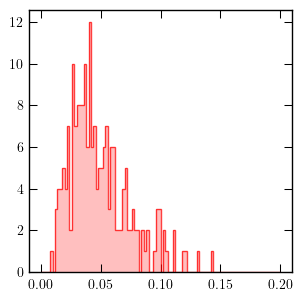

In [12]:
fig, ax = newplot("column")
print(specter_emd.shape)
hist_with_outline(ax, specter_emd, bins = 100, range = (0, 0.2), color = "red")

